# Variational Quantum Eigensolvers (VQE)

### Problem: Given a Hamiltonian $H$, find its ground state energy.

**Solution**: take advantage of the **variational principle**. 

Variational principle: given $H$ whose minimum eigenvalue is $\lambda_{min} \equiv \langle\psi_{min}\vert H \vert\psi_{min}\rangle$ and any wavefunction $\vert\psi\rangle$, 

$$
\lambda_{min} \leq \langle\psi\vert H \vert\psi\rangle
$$

**Method**: Iteratively update $\vert\psi\rangle$ and look for minima in $\langle\psi\vert H \vert\psi\rangle$.

### Let's do this for the single-qubit Hamiltionian

$$H = \sum\limits_{i\in(x,y,z)}\alpha_i\sigma_i$$

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

alpha_x = -1
alpha_y = 0
alpha_z = 1

sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

Hamiltonian = alpha_x * sigma_x + alpha_y * sigma_y + alpha_z * sigma_z
print(Hamiltonian)

[[ 1.+0.j -1.+0.j]
 [-1.+0.j -1.+0.j]]


You can decompose a Hamiltonian generally into the Pauli basis using well-known tricks. Here's a single-qubit example.

In [3]:
def get_hamiltonian_pauli_coeffs():

    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    
    a_x = 0.5*np.trace(np.matmul(Hamiltonian, sigma_x))
    a_y = 0.5*np.trace(np.matmul(Hamiltonian, sigma_y))
    a_z = 0.5*np.trace(np.matmul(Hamiltonian, sigma_z))
    
    return [a_x, a_y, a_z]

Hamiltonian = [[ 1, -1], [ -1, -1]]
[alpha_x, alpha_y, alpha_z] = get_hamiltonian_pauli_coeffs()
print(alpha_x, alpha_y, alpha_z)

-1.0 0j 1.0


### Method 1: Exact solution

In [4]:
from numpy import linalg as LA
eigenvalues, eigenvectors = LA.eig(Hamiltonian)
for ii, eigenvalue in enumerate(eigenvalues):
    print(f"Eigenvector {eigenvectors[:,ii]} has energy {eigenvalue}")

exact_eigenvector = eigenvectors[:,np.argmin(eigenvalues)]
exact_eigenvalue = np.min(eigenvalues)

Eigenvector [ 0.92387953 -0.38268343] has energy 1.414213562373095
Eigenvector [0.38268343 0.92387953] has energy -1.4142135623730951


### Method 2: VQE

We need three components. 
1. Create a candidate wavefunction $\vert\psi(\mathbf{\theta})\rangle$
2. Compute the expectation value $\langle\psi(\mathbf{\theta})\vert H \vert\psi(\mathbf{\theta})\rangle$
3. Set up an iterator that drives the above two functions

### Create $\vert\psi(\mathbf{\theta})\rangle$

In [5]:
from qiskit import QuantumCircuit

def create_psi(params):
    theta = params[0]
    phi = params[1]
    lam = params[2]
    mycircuit = QuantumCircuit(1)
    mycircuit.u3(theta, phi, lam, 0)
    
    return mycircuit

### Compute the expectation value of $\vert\psi(\mathbf{\theta})\rangle$

Notice that $\langle\psi(\mathbf{\theta})\vert H \vert\psi(\mathbf{\theta})\rangle = \sum\limits_{i\in(x,y,z)}\alpha_i\langle\psi(\mathbf{\theta})\vert\sigma_i\vert\psi(\mathbf{\theta})\rangle$

Also notice that in Qiskit, measurements are along $Z$ axis. In other words, a measurement in Qiskit is 

$$\text{measure}[\vert\psi(\mathbf{\theta})\rangle]\equiv \langle\psi(\mathbf{\theta})\vert\sigma_z\vert\psi(\mathbf{\theta})\rangle$$

Hence, to achieve the other axes of measurements, we need to apply the following tricks.

$$\langle\psi(\mathbf{\theta})\vert\sigma_x\vert\psi(\mathbf{\theta})\rangle =\langle\psi(\mathbf{\theta})\vert H\sigma_zH\vert\psi(\mathbf{\theta})\rangle = \text{measure}[H\vert\psi(\mathbf{\theta})\rangle]$$

and

$$\langle\psi(\mathbf{\theta})\vert\sigma_y\vert\psi(\mathbf{\theta})\rangle = \langle\psi(\mathbf{\theta})\vert S\sigma_xS^{\dagger}\vert\psi(\mathbf{\theta})\rangle = \langle\psi(\mathbf{\theta})\vert SH\sigma_zHS^{\dagger}\vert\psi(\mathbf{\theta})\rangle = \text{measure}[HS^{\dagger}\vert\psi(\mathbf{\theta})\rangle]$$


In [6]:
from copy import deepcopy
from qiskit import Aer, execute

def get_expectation_z(given_circuit):
    copied_circuit = deepcopy(given_circuit)
    copied_circuit.measure_all()
    result = execute(copied_circuit, backend=Aer.get_backend('qasm_simulator'), shots=10000).result()
    counts = result.get_counts(copied_circuit)
    
    if '1' not in counts:
        counts['1'] = 0
    if '0' not in counts:
        counts['0'] = 0
        
    return_value = 1.0 * counts['0'] - 1.0 * counts['1']
    
    return_value /= (counts['0'] + counts['1'])
    
    return return_value

def get_expectation_x(given_circuit):
    copied_circuit = deepcopy(given_circuit)
    copied_circuit.h(0)
    copied_circuit.measure_all()
    result = execute(copied_circuit, backend=Aer.get_backend('qasm_simulator'), shots=10000).result()
    counts = result.get_counts(copied_circuit)
    
    if '1' not in counts:
        counts['1'] = 0
    if '0' not in counts:
        counts['0'] = 0
        
    return_value = 1.0 * counts['0'] - 1.0 * counts['1']
    
    return_value /= (counts['0'] + counts['1'])
    
    return return_value

def get_expectation_y(given_circuit):
    copied_circuit = deepcopy(given_circuit)
    copied_circuit.sdg(0)
    copied_circuit.h(0)
    copied_circuit.measure_all()
    result = execute(copied_circuit, backend=Aer.get_backend('qasm_simulator'), shots=10000).result()
    counts = result.get_counts(copied_circuit)
    
    if '1' not in counts:
        counts['1'] = 0
    if '0' not in counts:
        counts['0'] = 0
        
    return_value = 1.0 * counts['0'] - 1.0 * counts['1']
    
    return_value /= (counts['0'] + counts['1'])
    
    return return_value

def get_expectation_value(given_circuit):
    expectation_x = get_expectation_x(given_circuit)    
    expectation_y = get_expectation_y(given_circuit)
    expectation_z = get_expectation_z(given_circuit)
    
    total_expectation = alpha_x * expectation_x + alpha_y * expectation_y + alpha_z * expectation_z
    
    return total_expectation

In [7]:
get_expectation_value(create_psi([0,0,0]))

(0.9938+0j)

### Set up classical iterator

In [8]:
from scipy.optimize import minimize

def run_once(params):
    global exp_values
    psi_circuit = create_psi(params)
    expectation_value = get_expectation_value(psi_circuit)
    exp_values.append(expectation_value)

    return expectation_value

def run_VQE(initial_params):
    
    ret = minimize(run_once, initial_params, method='COBYLA', 
                  options = {'tol': 1e-5, 'catol': 1e-5, 'maxiter':5000})

    final_value_angles = ret.x
    num_evals = ret.nfev
    final_expectation = ret.fun
    
    print(final_value_angles, num_evals, final_expectation)

In [9]:
exp_values = []
run_VQE([0,0,0])

[2.34563377 0.16772492 1.15394623] 47 -1.411


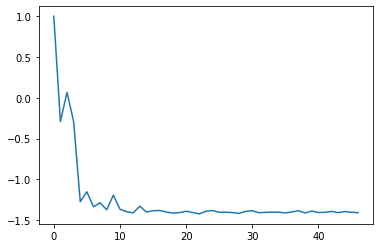

In [10]:
import matplotlib.pyplot as plotter
plotter.plot(exp_values)

### Doing all of this in Qiskit Aqua automatically

The Aqua element of Qiskit makes it incredibly easy to do all of the above work in a few easy steps.

In [11]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.1',
 'qiskit-aer': '0.5.1',
 'qiskit-ignis': '0.3.0',
 'qiskit-ibmq-provider': '0.7.1',
 'qiskit-aqua': '0.7.1',
 'qiskit': '0.19.2'}

In [12]:
from qiskit.aqua.operators import *

Let's rewrite the Hamiltonian matrix from above.

In [13]:
Hamiltonian = [[1, -1], [ -1, -1]]
print(Hamiltonian)

[[1, -1], [-1, -1]]


Use Aqua's operator flow to turn this matrix into an operator. You can also see the Pauli representation.

In [14]:
hamiltonian_operator = MatrixOperator(Hamiltonian).to_opflow()
print(hamiltonian_operator.to_pauli_op())

SummedOp(
[-1.0 * X,
Z])


In case we want to start by defining the Hamiltonian in Pauli notation, we can define it as follows.

In [15]:
hamiltonian_operator = (1 * Z) + (-1 * X)
print(hamiltonian_operator)
print()
print(hamiltonian_operator.to_matrix())

SummedOp(
[Z,
-1.0 * X])

[[ 1.+0.j -1.+0.j]
 [-1.+0.j -1.+0.j]]


As you can see above, the matrix form and the Pauli form are interchangeable in Aqua's operator flow. What remains is to set up VQE using `hamiltonian_operator` and a specific type of trial wavefunction. We will use a custom circuit here to prepare the trial wavefunction.

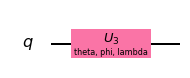

In [16]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

wavefunction = QuantumCircuit(1)
wavefunction.u3(Parameter('theta'), Parameter('phi'), Parameter('lambda'), 0)
wavefunction.draw()

And finally, let's set up VQE with our Hamiltonian operator and trial wavefunctions.

In [17]:
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit import Aer

optimizer = COBYLA(maxiter=100)
backend = Aer.get_backend('statevector_simulator')
vqe = VQE(var_form = wavefunction, operator=hamiltonian_operator, 
          optimizer=optimizer, quantum_instance=backend, )
result = vqe.compute_minimum_eigenvalue()
print('Minimum energy:', result.eigenvalue)
print('Optimal parameters: ', result.optimal_parameters)
print('Eigenstate with min energy:', result.eigenstate)

Minimum energy: (-1.41421355943526+0j)
Optimal parameters:  {Parameter(lambda): -1.6851285382809378, Parameter(phi): -3.141507591805213, Parameter(theta): -2.3561713194420064}
Eigenstate with min energy: [0.38269414+0.00000000e+00j 0.9238751 +7.85864645e-05j]


### A Chemistry example

Let's use the above examples to see how we can find the ground state energy of the Hydrogen molecule.

As always, we start by defining the Hamiltonian. We will discuss later how this Hamiltonian can also be found easily using Qiskit.

In [18]:
h2_hamiltonian =(-1.0523732 * I^I) + \
                (0.39793742 * I^Z) + \
                (-0.3979374 * Z^I) + \
                (-0.0112801 * Z^Z) + \
                (0.18093119 * X^X)

Note that the Hamiltonian describes Pauli operators on two qubits. `Z ^ I` means `Z` on the first qubit, and `I` (identity) on the second.

Next, we set up the circuit that prepares the trial wavefunctions. We will set up an ansatz using the `EfficientSU2` circuit in Qiskit's circuit library with 2 qubits and 3 repetitions. By default, this will place `Ry` and `Rz` single-gates with two-qubit `CX` gates between each repetition.

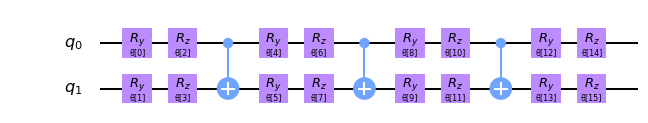

In [19]:
from qiskit.circuit.library import EfficientSU2
wavefunction = EfficientSU2(num_qubits = h2_hamiltonian.num_qubits, reps=3)
wavefunction.draw()

Finally, we set up VQE with the Hamiltonian, the variational form that we have defined, and the `COBYLA` optimizer.

In [20]:
optimizer = COBYLA(maxiter=500)
backend = Aer.get_backend('statevector_simulator')
vqe = VQE(var_form = wavefunction, operator = h2_hamiltonian, 
          optimizer = optimizer, quantum_instance = backend)
result = vqe.compute_minimum_eigenvalue()
print('Minimum energy:', result.eigenvalue)
print('Optimal parameters: ', result.optimal_parameters)
print('Eigenstate with min energy:', result.eigenstate)

Minimum energy: (-1.85727495584387+0j)
Optimal parameters:  {Parameter(θ[0]): 0.12343808843366767, Parameter(θ[10]): 3.0743639600000314, Parameter(θ[11]): 2.2456576901437124, Parameter(θ[12]): 0.6827267374849265, Parameter(θ[13]): -1.3915877918847848, Parameter(θ[14]): -2.0261115199849016, Parameter(θ[15]): 1.169662494111262, Parameter(θ[1]): 2.1844473491124017, Parameter(θ[2]): 0.9057955619273581, Parameter(θ[3]): -0.6175760642366862, Parameter(θ[4]): -0.047121312642847676, Parameter(θ[5]): -1.5191999109481857, Parameter(θ[6]): 1.152769468914966, Parameter(θ[7]): -0.6441448857574456, Parameter(θ[8]): -2.346647673956139, Parameter(θ[9]): -2.3062691903567414}
Eigenstate with min energy: [-2.19754811e-05-1.50008203e-05j -9.93441391e-01+2.51232439e-02j
  1.11513039e-01-2.80479184e-03j -2.12891680e-05-9.17746269e-07j]


As you can see above, the final result is a minimum energy of -1.857274. The reference energy is -1.857275, so we're not too far off.